In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import interact widget from ipywidgets
from ipywidgets import interact
np.random.seed(0)

## Building the network

In [2]:
# defining the derivative of the membrane potential
def dhdt(h, I, tau, R):
    return (R * I - h) / tau
# defining the transfer function
def transfer(h, alpha, beta):
    return (1/(1 + np.exp(-2 * alpha * (h - beta))))
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [3]:
def interactive_activation(alpha=.2, beta=.5):
    h_list = np.linspace(-10, 10, 1000)
    activation_list = transfer(h_list, alpha=alpha, beta=beta)

    plt.plot(h_list, activation_list, label='transfer function')
    plt.xlabel('h')
    plt.ylabel('transfer function')
    plt.legend()
    plt.show()

_ = interact(interactive_activation, alpha=(0.1, 2, 0.1), beta=(0.1, 2, 0.1))

interactive(children=(FloatSlider(value=0.2, description='alpha', max=2.0, min=0.1), FloatSlider(value=0.5, de…

## 0.1. Plot the transfer function g as a function of the potential h. How do α and β affect the shape?
- $\alpha$ is changing the slope of the transfer function, the higher the value the steeper the slope.
- $\beta$ is shifting the transfer function. The higher the value the more shifted to the right.



In [4]:
T = 1000 # ms
dt = .1 # ms
tau = 10 # ms
R = 1 # Ohm # needs to be asked on the units
r0 = 1 # mHz
alpha = 2 # mV^-1
beta = .5 # mV

N = 10 # number of neurons
h = np.zeros((N, int(T/dt)))
t = np.linspace(0, T, int(T/dt))
I0 = 2 # 1e-6 # nA
omega = 2e-2 # Hz
# I = np.zeros((N, int(T/dt))) # input current
# I_noisy = np.random.normal(0, 1, (N, int(T/dt)))
I = I0 * np.sin(omega * np.linspace(0, T, int(T/dt)))
# repeating the input current for all neurons
I = np.tile(I, (N, 1))
# I[:,:] = I0 * np.sin(omega * t)
rate = np.zeros((N, int(T/dt)))
spikes = np.zeros((N, int(T/dt)))

Text(0, 0.5, 'Current (A)')

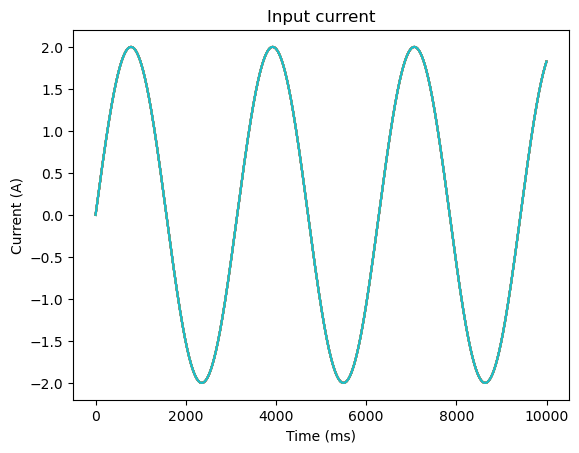

In [5]:
plt.plot(I.T)# + np.random.normal(0, .1, I.shape).T);
plt.title('Input current')
plt.xlabel('Time (ms)')
plt.ylabel('Current (A)')

In [6]:
for t in range(1, int(T/dt)):
    h[:, t] = h[:, t-1] + dt * dhdt(h[:, t-1], I[:, t-1], tau, R)
    rate[:, t] = r0 * transfer(h[:, t], alpha, beta)
    # spikes[:, t] = np.random.poisson(rate[:, t] * dt) > 0
    # if np.random.rand() > (rate[:, t] * dt).any():
        # spikes[:, t] = 1
    spikes[:, t] = np.random.binomial(1, rate[:, t] * dt)
    # if .any() > 0:
        # spikes[:, t] = 1
    

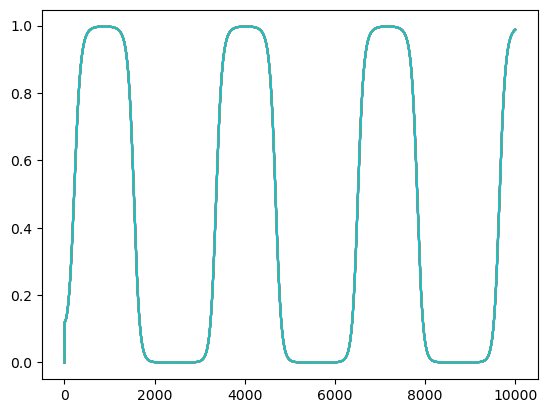

In [7]:
# plotting the rate of the neurons
for n in range(N):
    plt.plot(rate[n, :])# + np.random.normal(0, .01, rate.shape[1]), label=f'neuron {n}')

Text(0.5, 1.0, 'Spike raster')

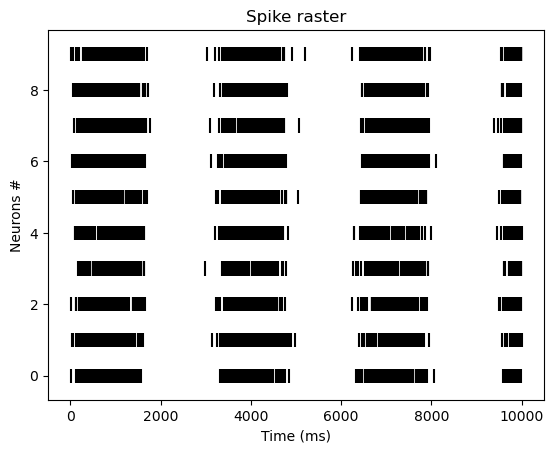

In [8]:
# plotting the spike raster
for n in range(N):
    spikes_n = np.where(spikes[n, :])[0]
    plt.vlines(spikes_n, n-.2, n+.2, color='black')
plt.xlabel('Time (ms)')
plt.ylabel('Neurons #')
plt.title('Spike raster')

In [9]:
def calculate_mean_rate(N, T, dt, spikes):
    # calculating the mean rate of the neurons
    mean_rate = np.zeros((N, T))
    bin_size = 10
    for t in np.arange(0, int(T/dt), bin_size):
        mean_rate[:, int(t*dt)] = np.mean(spikes[:, t:t+bin_size], axis=1)
    return mean_rate

Text(0.5, 0, 'Time (ms)')

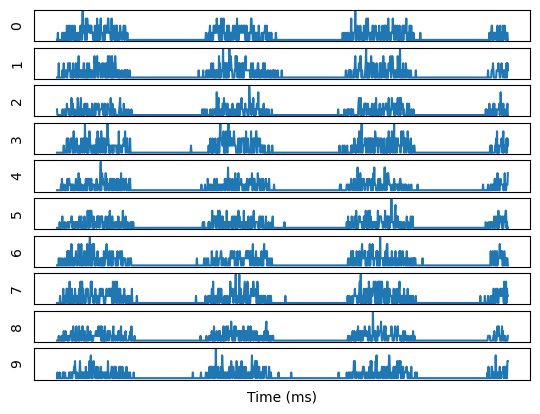

In [10]:
# calculating the mean rate of the neurons
# mean_rate = np.zeros((N, T))
# for t in np.arange(0, int(T/dt), 10):
#     mean_rate[:, int(t*dt)] = np.mean(spikes[:, t:t+10], axis=1)
mean_rate = calculate_mean_rate(N, T, dt, spikes)
# plotting the mean rate of the neurons 1 -10
plt.title('Mean rate of the neurons 1-10')
for n in range(10):
    plt.subplot(10, 1, n+1)
    plt.plot(mean_rate[n, :])
    plt.ylabel(f'{n}')
    plt.xticks([]); plt.yticks([])
plt.xlabel('Time (ms)')


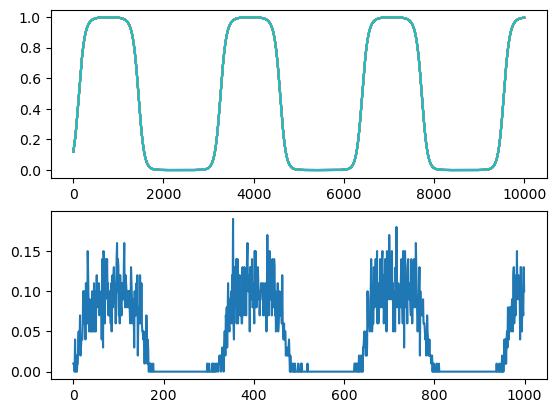

In [11]:
# comparing the theoretical rate with the mean rate of spiking neurons
theoretical_rate = r0 * transfer(R*I, alpha, beta)
plt.subplot(211)
plt.plot(theoretical_rate.T);
plt.subplot(212)
plt.plot(np.mean(mean_rate, axis=0))
# plt.plot(mean_rate[0, :])

## 0.2
- Since the spike generation is stochastic, the rate doesn't go as high as 1 (which is the maximum theoretical rate)
But it can go as high as .5 at some times.
- As long as there's no interactions between the neurons, the size of the network doesn't affect the simulation results.
- The numerical mean rate over the population tends to be smaller than the theoretical rate by a factor of 10 but it correctly follows the temporal aspects of the theoretical firing rate!

In [12]:
T = 1000 # ms
dt = .1 # ms
J = 5 # pC
N = 100
X = np.linspace(0, 2 * np.pi, N)
I = np.zeros((N, int(T/dt)))
h = np.random.uniform(0, 1, (N, int(T/dt)))
# h = np.zeros((N, int(T/dt)))
spikes = np.zeros((N, int(T/dt)))
rate = np.zeros((N, int(T/dt)))
tau = 10 # ms
R = 1 # Ohm # needs to be asked on the units
r0 = 1 # mHz
alpha = 2 # mV^-1
beta = .5 # mV

# for t in range(1, int(T/dt)):
for t in range(1, 2):
    m_cos = np.mean(np.cos(X) * spikes[:, t])
    m_sin = np.mean(np.sin(X) * spikes[:, t])
    # print(m_cos)
    I[:, t] = J/dt * (np.cos(X) * m_cos + np.sin(X) * m_sin)
    # print(I.shape)
    h[:, t] = h[:, t-1] + dt * dhdt(h[:, t-1], I[:, t-1], tau, R)
    rate[:, t] = r0 * transfer(h[:, t], alpha, beta)
    spikes[:, t] = np.random.binomial(1, rate[:, t] * dt)
    

In [13]:
def interactive_activation(J = 5):
    T = 100 # ms
    dt = .1 # ms
    N = 100
    X = np.linspace(0, 2 * np.pi, N)
    I = np.zeros((N, int(T/dt)))
    h = np.random.uniform(0, 1, (N, int(T/dt)))
    tau = 10 # ms
    R = 1 # Ohm # needs to be asked on the units
    r0 = 10 # mHz
    alpha = 2 # mV^-1
    beta = .5 # mV
    # h = np.zeros((N, int(T/dt)))
    spikes = np.zeros((N, int(T/dt)))
    rate = np.zeros((N, int(T/dt)))
    m_cos = 0
    m_sin = 0

    # spikes = np.random.binomial(1, np.ones(N) * dt, (N, int(T/dt)))
    # h = np.random.normal(0, 1, (N, int(T/dt)))
    for t in range(1, int(T/dt)):
        I[:, t] = J * (np.cos(X) * m_cos + np.sin(X) * m_sin)
        h[:, t] = h[:, t-1] + dt * dhdt(h[:, t-1], I[:, t-1], tau, R)
        rate[:, t] = r0 * transfer(h[:, t], alpha, beta)
        spikes[:, t] = np.random.binomial(1, rate[:, t] * dt)
        m_cos = np.mean(np.cos(X) * spikes[:, t])
        m_sin = np.mean(np.sin(X) * spikes[:, t])
    
    # figure = plt.figure(figsize=(10, 5))
    plt.subplot(311)
    plt.plot(I.T, color = 'black', alpha = .1)
    plt.ylabel('Input current')
    plt.subplot(312)
    plt.plot(rate.T, color = 'red', alpha = .1)
    plt.ylabel('Rate')
    plt.subplot(313)
    # plotting the spike raster
    for n in range(N):
        spikes_n = np.where(spikes[n, :])[0]
        plt.vlines(spikes_n, n-.5e1, n+.5e1, color='black')
    plt.xlabel('Time (ms)')
    plt.ylabel('Neurons #')
    plt.title('Spike raster')

_ = interact(interactive_activation, J=(0, 20, .1))

interactive(children=(FloatSlider(value=5.0, description='J', max=20.0), Output()), _dom_classes=('widget-inte…

## 1.1
The value $j=5 pC$ consistantly produce a bump attractor, although there are itterations for which $j=4 pC$ also shows the bump dynamics.

Text(0, 0.5, 'Rate')

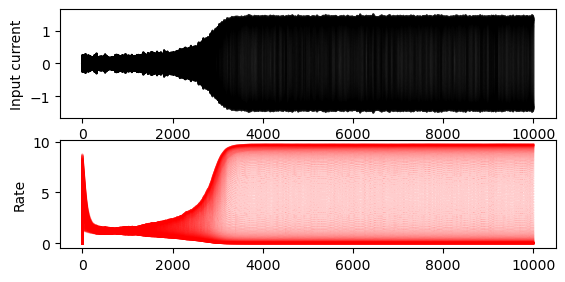

In [14]:
T = 1000 # ms
dt = .1 # ms
N = 300
X = np.linspace(0, 2 * np.pi, N)
I = np.zeros((N, int(T/dt)))
h = np.random.uniform(0, 1, (N, int(T/dt)))
tau = 10 # ms
R = 1 # Ohm # needs to be asked on the units
r0 = 10 # mHz
alpha = 2 # mV^-1
beta = .5 # mV
# h = np.zeros((N, int(T/dt)))
spikes = np.zeros((N, int(T/dt)))
rate = np.zeros((N, int(T/dt)))
m_cos = 0
m_sin = 0

# spikes = np.random.binomial(1, np.ones(N) * dt, (N, int(T/dt)))
# h = np.random.normal(0, 1, (N, int(T/dt)))
for t in range(1, int(T/dt)):
    I[:, t] = J * (np.cos(X) * m_cos + np.sin(X) * m_sin)
    h[:, t] = h[:, t-1] + dt * dhdt(h[:, t-1], I[:, t-1], tau, R)
    rate[:, t] = r0 * transfer(h[:, t], alpha, beta)
    spikes[:, t] = np.random.binomial(1, rate[:, t] * dt)
    m_cos = np.mean(np.cos(X) * spikes[:, t])
    m_sin = np.mean(np.sin(X) * spikes[:, t])

# figure = plt.figure(figsize=(10, 5))
plt.subplot(311)
plt.plot(I.T, color = 'black', alpha = .1)
plt.ylabel('Input current')
plt.subplot(312)
plt.plot(rate.T, color = 'red', alpha = .1)
plt.ylabel('Rate')
# plt.subplot(313)
# # plotting the spike raster
# for n in range(N):
#     spikes_n = np.where(spikes[n, :])[0]
#     plt.vlines(spikes_n, n-.5e1, n+.5e1, color='black')
# plt.xlabel('Time (ms)')
# plt.ylabel('Neurons #')
# plt.title('Spike raster')

# 1.2
The location of the bump becomes stable after a while.

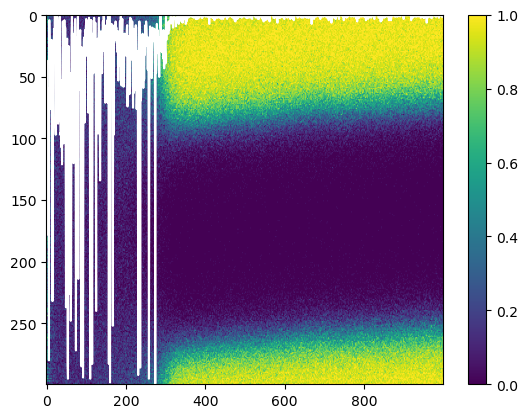

In [15]:
mean_rate = calculate_mean_rate(N, T, dt, spikes)
mean_over_time = np.mean(mean_rate, axis=1)
plt.imshow(mean_rate, aspect='auto')
plt.colorbar()

max_neuron_rate = []
for t in range(1, T):
    max_neuron_rate.append(np.argmax(mean_rate[:, t]))
# mean_over_neurons = np.mean(mean_rate, axis=0)
plt.plot(max_neuron_rate, color='white')


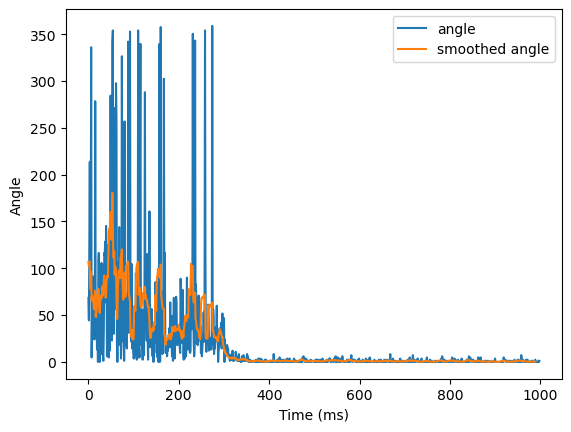

In [16]:
# the angle of the neuron with the maximum rate
def map_to_360(value, N):
    return (value / N) * 360
max_neuron_rate = np.array(max_neuron_rate)
max_angle = map_to_360(max_neuron_rate, N)
smoothed_max_angle = np.convolve(max_angle, np.ones(10), 'valid') / 10
plt.plot(max_angle, label = 'angle')
plt.plot(smoothed_max_angle, label = 'smoothed angle')
plt.ylabel('Angle')
plt.xlabel('Time (ms)')
plt.legend()

In [17]:
# circular_angle = np.zeros((N, T))
# bump_angle = np.zeros(T)
# for t in range(T):
#     circular_angle[:, t] = mean_rate[:,t] * np.exp(1j * X).T
#     x = mean_rate[:,t] * np.exp(1j * X).T
#     bump_angle[t] = np.angle(np.sum(x))
    

# 1.3
The larger the N the more the more drift we saw.
The $\tau$ and $dt$ are making the dynamic faster and quicker to evolve. If there's a drift present in the dynamic, larger $\tau$ and $dt$ will show pronounce it. Basically, larger $\tau$ and larger $dt$ will make the system approach faster to their stable behavior (fixed points).

# 1.4

In [18]:
def external_input(X, mu, sigma):
    return np.random.normal(X - mu, sigma, X.shape)
    # return np.random.normal(mu, sigma, h.shape)

Text(0.5, 1.0, 'Spike raster')

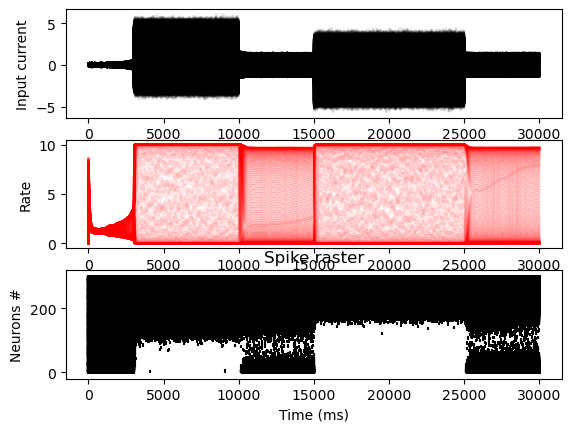

In [19]:
T = 3000 # ms
dt = .1 # ms
N = 300
X = np.linspace(0, 2 * np.pi, N)
I = np.zeros((N, int(T/dt)))

h = np.random.uniform(0, 1, (N, int(T/dt)))
tau = 10 # ms
R = 1 # Ohm # needs to be asked on the units
r0 = 10 # mHz
alpha = 2 # mV^-1
beta = .5 # mV
# h = np.zeros((N, int(T/dt)))
spikes = np.zeros((N, int(T/dt)))
rate = np.zeros((N, int(T/dt)))
m_cos = 0
m_sin = 0

# spikes = np.random.binomial(1, np.ones(N) * dt, (N, int(T/dt)))
# h = np.random.normal(0, 1, (N, int(T/dt)))
for t in range(1, int(T/dt)):
    if t >= int(300/dt) and t < int(1000/dt):
        external_input_at_t = external_input(X, 2 * np.pi / 3, np.pi/8)
    elif t >= int(1500/dt) and t < int(2500/dt):
        external_input_at_t = external_input(X, 4 * np.pi / 3, np.pi/8)
    else:
        external_input_at_t = np.zeros(N)
    I[:, t] = J * (np.cos(X) * m_cos + np.sin(X) * m_sin) + external_input_at_t
    h[:, t] = h[:, t-1] + dt * dhdt(h[:, t-1], I[:, t-1], tau, R)
    rate[:, t] = r0 * transfer(h[:, t], alpha, beta)
    spikes[:, t] = np.random.binomial(1, rate[:, t] * dt)
    m_cos = np.mean(np.cos(X) * spikes[:, t])
    m_sin = np.mean(np.sin(X) * spikes[:, t])

# figure = plt.figure(figsize=(10, 5))
plt.subplot(311)
plt.plot(I.T, color = 'black', alpha = .1)
plt.ylabel('Input current')
plt.subplot(312)
plt.plot(rate.T, color = 'red', alpha = .1)
plt.ylabel('Rate')
plt.subplot(313)
# plotting the spike raster
for n in range(N):
    spikes_n = np.where(spikes[n, :])[0]
    plt.vlines(spikes_n, n-.5e1, n+.5e1, color='black')
plt.xlabel('Time (ms)')
plt.ylabel('Neurons #')
plt.title('Spike raster')

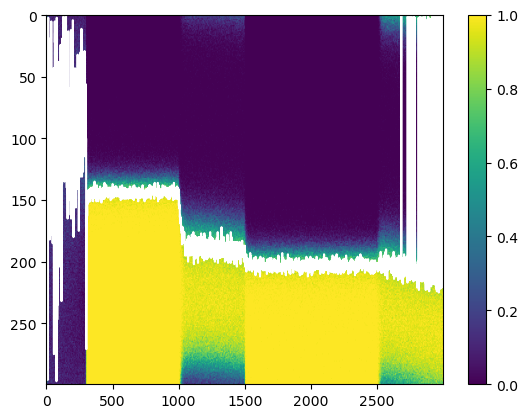

In [20]:
mean_rate = calculate_mean_rate(N, T, dt, spikes)
mean_over_time = np.mean(mean_rate, axis=1)
plt.imshow(mean_rate, aspect='auto')
plt.colorbar()

max_neuron_rate = []
for t in range(1, T):
    max_neuron_rate.append(np.argmax(mean_rate[:, t]))
# mean_over_neurons = np.mean(mean_rate, axis=0)
plt.plot(max_neuron_rate, color='white')


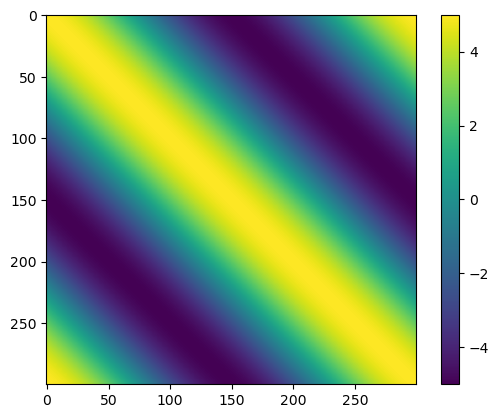

In [21]:
# Paramètres du réseau
# Fonction de connectivité
def connectivity_profile(xi, xj):
    return J * np.cos(xi - xj)

# Création de la matrice de connectivité
connectivity_matrix = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        connectivity_matrix[i, j] = connectivity_profile(X[i], X[j])

# Affichage de la matrice de connectivité
plt.imshow(connectivity_matrix)
plt.colorbar()

# 1.4
The connectivity matrix will tells us how neurons interact with each other. Neurons that have distance equal to $|X_i - X_j| = \pi/2$ doesn't interact with each other as $w(x_i,x_j)=\cos(\pi/2)=0$ while other neurons with distance of $\pi$ can inhibit each other as $\cos(\pi)=-1$.
So giving an external input which only activates a subgroup of neurons will lead the neurons to talk to each other based on their connectivity matrix. So these active neurons due to external input will silent those neurons that have distance of equal $\pi$ while exhibit those who have of distance $0$ and doesn't do anything to those with distance $\pi/2$.
The external inputs will drive the network towards the mean angle $\mu$ and then the internal interactions do its job which is exciting and inhibting other neurons that are encoding other angles.


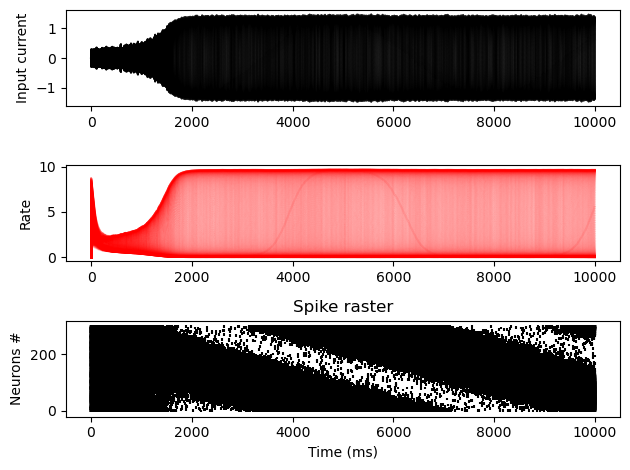

In [22]:
T = 1000 # ms
dt = .1 # ms
N = 300
X = np.linspace(0, 2 * np.pi, N)
X1 = np.linspace(0, 2 * np.pi, N) + np.pi/30
I = np.zeros((N, int(T/dt)))
h = np.random.uniform(0, 1, (N, int(T/dt)))
tau = 10 # ms
R = 1 # Ohm # needs to be asked on the units
r0 = 10 # mHz
alpha = 2 # mV^-1
beta = .5 # mV
# h = np.zeros((N, int(T/dt)))
spikes = np.zeros((N, int(T/dt)))
rate = np.zeros((N, int(T/dt)))
m_cos = 0
m_sin = 0

# spikes = np.random.binomial(1, np.ones(N) * dt, (N, int(T/dt)))
# h = np.random.normal(0, 1, (N, int(T/dt)))
for t in range(1, int(T/dt)):
    I[:, t] = J * (np.cos(X1) * m_cos + np.sin(X1) * m_sin)
    h[:, t] = h[:, t-1] + dt * dhdt(h[:, t-1], I[:, t-1], tau, R)
    rate[:, t] = r0 * transfer(h[:, t], alpha, beta)
    spikes[:, t] = np.random.binomial(1, rate[:, t] * dt)
    m_cos = np.mean(np.cos(X) * spikes[:, t])
    m_sin = np.mean(np.sin(X) * spikes[:, t])

# figure = plt.figure(figsize=(10, 5))
plt.subplot(311)
plt.plot(I.T, color = 'black', alpha = .1)
plt.ylabel('Input current')
plt.subplot(312)
plt.plot(rate.T, color = 'red', alpha = .1)
plt.ylabel('Rate')
plt.subplot(313)
# plotting the spike raster
for n in range(N):
    spikes_n = np.where(spikes[n, :])[0]
    plt.vlines(spikes_n, n-.5e1, n+.5e1, color='black')
plt.xlabel('Time (ms)')
plt.ylabel('Neurons #')
plt.title('Spike raster')
plt.tight_layout()

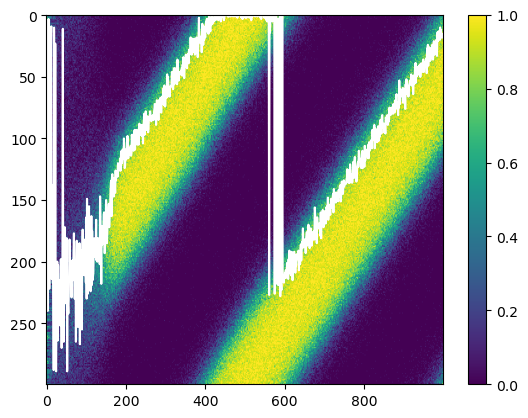

In [23]:
mean_rate = calculate_mean_rate(N, T, dt, spikes)
mean_over_time = np.mean(mean_rate, axis=1)
plt.imshow(mean_rate, aspect='auto')
plt.colorbar()

max_neuron_rate = []
for t in range(1, T):
    max_neuron_rate.append(np.argmax(mean_rate[:, t]))
# mean_over_neurons = np.mean(mean_rate, axis=0)
plt.plot(max_neuron_rate, color='white')


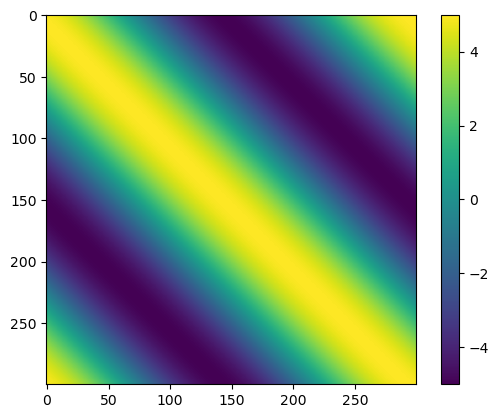

In [24]:
# calculating the connectivity matrix 
connectivity_matrix = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        connectivity_matrix[i, j] = connectivity_profile(X[i] - np.pi/20, X[j])

# plotting the connectivity matrix
plt.imshow(connectivity_matrix)
plt.colorbar()

# 1.5 
Adding this small shift in angle in the connectivity matrix will cause a non-symmetric connection profile for each neuron. This time each neuron has stronger connection between one side neighbours compare to the other side.
This effectively means that each neuron's connectivity profile is slightly shifted by the angle $\phi$. The effect of this shift is to introduce a preferred direction of motion for the bump, causing it to drift.
The bump of activity will no longer remain stationary.The bump will drift in the direction corresponding to the sign of $\phi$. This drift occurs because the neurons are now more strongly connected to their neighbors in one direction, creating an imbalance that causes the bump to move periodically.


# Exercise 2
# 2.1
The input that each neuron in $L$ population receives is:
$$
I_i^L = \frac{J^L}{N} \sum_{j=1}^{N^L} w_{L \rightarrow L}(x_i^L, x_j^L) S_j^L(t) 
 + \frac{J^R}{N} \sum_{j=1}^{N^R} w_{R \rightarrow L}(x_i^R, x_j^R) S_j^R(t)
$$
and the input that each neuron in $R$ population receives is:
$$
I_i^R = \frac{J^R}{N} \sum_{j=1}^{N^R} w_{R \rightarrow R}(x_i^R, x_j^R) S_j^R(t)
+ \frac{J^L}{N} \sum_{j=1}^{N^L} w_{L \rightarrow R}(x_i^L, x_j^L) S_j^L(t) 
$$

We can explain this mechanism by examining the connectivity weights between populations. Connectivity weights are defined by cosine functions with a shift $θ$, meaning that when activity is maximal in one population, it is minimal in the other. For example, if the activity bump moves to the right in the left population, this inhibits the corresponding part of the right population, keeping the total input in the linear regime.

In a stable configuration, the activity bump is held in place by this dynamic equilibrium. If the bump starts to move in one direction, the push-pull system is activated to stabilize it. For example, if the bump moves to the right in the left population, this increases activity in the right part of that population. However, due to connectivity weights, this inhibits the left part of the right population, pushing the bump in this population to the left. This process balances out, preventing the bump from moving indefinitely and thus maintaining a stable configuration.




# 2.2
To stablize the center of the two bumps at $\pi$ we initialzed the membrane potential of each neuron such that the neurons corresponding the angle $\pi$ has the maximum value of 1 by pushing a normal distribution around those neurons. The both ends of neurons therefore has small values (~ 0). This ensures that the center of the bump remains around $\pi$.

Text(0.5, 1.0, 'Spike raster')

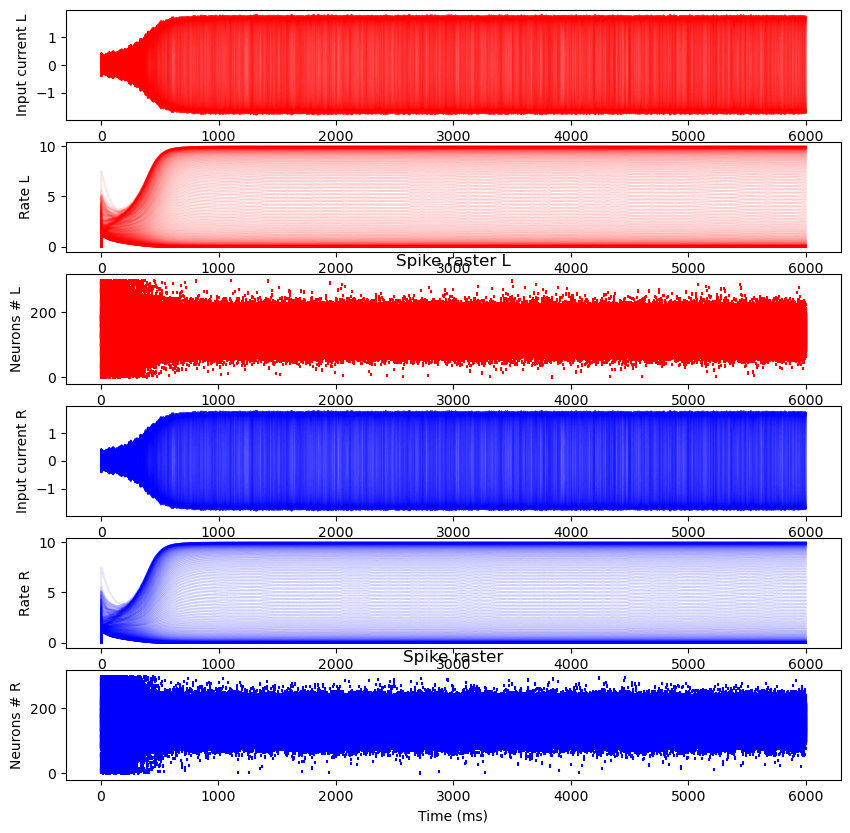

In [46]:
# global parameters
T = 600 # ms
dt = .1 # ms
N = 300
tau = 10 # ms
R = 1 # Ohm # needs to be asked on the units
r0 = 10 # mHz
alpha = 2 # mV^-1
beta = .5 # mV

# parameters for the left and right populations
Xl = np.linspace(0, 2 * np.pi, N)
Xr = np.linspace(0, 2 * np.pi, N)
theta_l = 10 * np.pi / 180
theta_r = 10 * np.pi / 180
Il = np.zeros((N, int(T/dt)))
Ir = np.zeros((N, int(T/dt)))
hl = np.random.uniform(0, 1, (N, int(T/dt)))
hr = np.random.uniform(0, 1, (N, int(T/dt)))
spikes_l = np.zeros((N, int(T/dt)))
spikes_r = np.zeros((N, int(T/dt)))
rate_l = np.zeros((N, int(T/dt)))
rate_r = np.zeros((N, int(T/dt)))
m_cos_l = 0
m_cos_r = 0
m_sin_l = 0
m_sin_r = 0
Jl = 3
Jr = 3
# initial conditions for h such that the center of the bump remains around pi
# creating initial values for the neurons such that the centering neuron has the highest rate
peak_index = 150
std_dev = 50
indices = np.arange(N)
normal_dist = np.exp(-((indices - peak_index) ** 2) / (2 * std_dev ** 2))
initial_array = normal_dist * np.random.normal(0, .3, N)
initial_array = np.abs(initial_array)

hl[:, 0] = initial_array
hr[:, 0] = initial_array
# simulation of both populations
for t in range(1, int(T/dt)):
    Il[:, t] = Jl * (np.cos(Xl+theta_l) * m_cos_l + np.sin(Xl+theta_l) * m_sin_l) + Jr * (np.cos(Xl+theta_l) * m_cos_r + np.sin(Xl+theta_l) * m_sin_r)
    Ir[:, t] = Jr * (np.cos(Xr-theta_r) * m_cos_r + np.sin(Xr-theta_r) * m_sin_r) + Jl * (np.cos(Xr-theta_r) * m_cos_l + np.sin(Xr-theta_r) * m_sin_l)

    hl[:, t] = hl[:, t-1] + dt * dhdt(hl[:, t-1], Il[:, t-1], tau, R)
    hr[:, t] = hr[:, t-1] + dt * dhdt(hr[:, t-1], Ir[:, t-1], tau, R)
    
    rate_l[:, t] = r0 * transfer(hl[:, t], alpha, beta)
    rate_r[:, t] = r0 * transfer(hr[:, t], alpha, beta)
    
    spikes_l[:, t] = np.random.binomial(1, rate_l[:, t] * dt)
    spikes_r[:, t] = np.random.binomial(1, rate_r[:, t] * dt)
    
    m_cos_l = np.mean(np.cos(Xl) * spikes_l[:, t])
    m_cos_r = np.mean(np.cos(Xr) * spikes_r[:, t])
    
    m_sin_l = np.mean(np.sin(Xl) * spikes_l[:, t])
    m_sin_r = np.mean(np.sin(Xr) * spikes_r[:, t])

figure = plt.figure(figsize=(10, 10))
plt.subplot(611)
plt.plot(Il.T, color = 'red', alpha = .1)
plt.ylabel('Input current L')
plt.subplot(612)
plt.plot(rate_l.T, color = 'red', alpha = .1)
plt.ylabel('Rate L')
plt.subplot(613)
# plotting the spike raster
for n in range(N):
    spikes_n = np.where(spikes_l[n, :])[0]
    plt.vlines(spikes_n, n-.5e1, n+.5e1, color='red')
plt.xlabel('Time (ms)')
plt.ylabel('Neurons # L')
plt.title('Spike raster L')

plt.subplot(614)
plt.plot(Ir.T, color = 'blue', alpha = .1)
plt.ylabel('Input current R')
plt.subplot(615)
plt.plot(rate_r.T, color = 'blue', alpha = .1)
plt.ylabel('Rate R')
plt.subplot(616)
# plotting the spike raster
for n in range(N):
    spikes_n = np.where(spikes_r[n, :])[0]
    plt.vlines(spikes_n, n-.5e1, n+.5e1, color='blue')
plt.xlabel('Time (ms)')
plt.ylabel('Neurons # R')
plt.title('Spike raster')

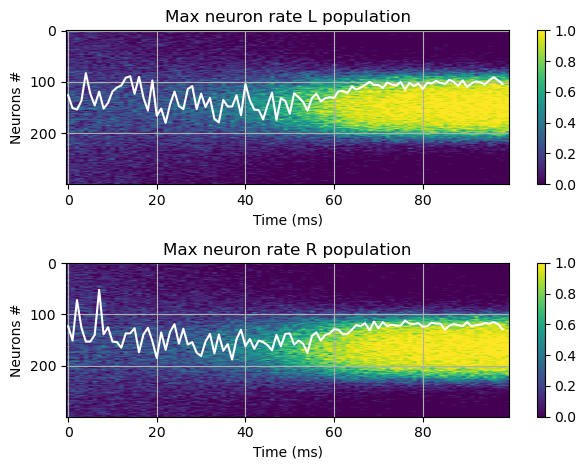

In [42]:
plt.subplot(211)
mean_rate_l = calculate_mean_rate(N, T, dt, spikes_l)
mean_over_time_l = np.mean(mean_rate_l, axis=1)
plt.imshow(mean_rate_l, aspect='auto')
plt.colorbar()
max_neuron_rate_l = []
for t in range(1, T):
    max_neuron_rate_l.append(np.argmax(mean_rate_l[:, t]))
plt.plot(max_neuron_rate_l, color='white')
plt.title('Max neuron rate L population')
plt.ylabel('Neurons #')
plt.xlabel('Time (ms)')
plt.grid()
plt.subplot(212)
mean_rate_r = calculate_mean_rate(N, T, dt, spikes_r)
mean_over_time_r = np.mean(mean_rate_r, axis=1)
plt.imshow(mean_rate_r, aspect='auto')
plt.colorbar()
max_neuron_rate_r = []
for t in range(1, T):
    max_neuron_rate_r.append(np.argmax(mean_rate_r[:, t]))
plt.plot(max_neuron_rate_r, color='white')
plt.title('Max neuron rate R population')
plt.ylabel('Neurons #')
plt.xlabel('Time (ms)')
plt.grid()
plt.tight_layout()

# 2.3

For strong values of external input (~ $\pm 1.5$) the bump will disappear. This disapearing of bump will be different for each population as for one population all of the neurons become active and for the other population all of the neurons become inactive. But for both populations, there's no significant difference between the activity of neurons within the population (therefore, no bump).
Once the external input goes away $(t > 600 ms)$ the two network has the chance to reconfigure their bumps. But this time, since there's no strong initialization the bump will be at a random position.

Text(0.5, 1.0, 'Spike raster')

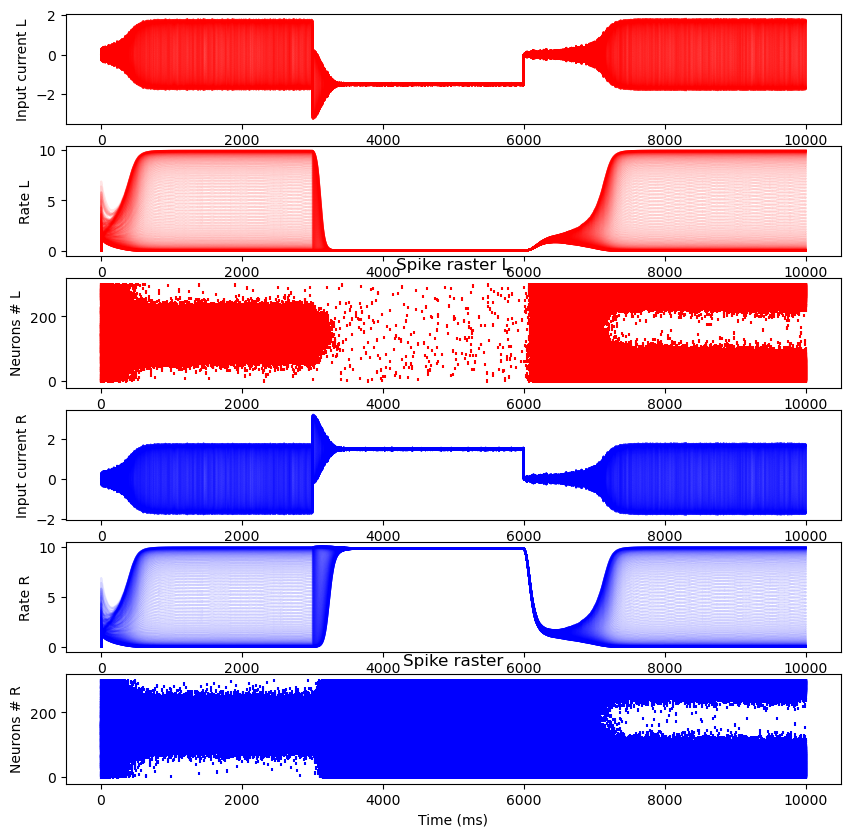

In [52]:
# global parameters
T = 1000 # ms
dt = .1 # ms
N = 300
tau = 10 # ms
R = 1 # Ohm # needs to be asked on the units
r0 = 10 # mHz
alpha = 2 # mV^-1
beta = .5 # mV

# parameters for the left and right populations
Xl = np.linspace(0, 2 * np.pi, N)
Xr = np.linspace(0, 2 * np.pi, N)
theta_l = 10 * np.pi / 180
theta_r = 10 * np.pi / 180
Il = np.zeros((N, int(T/dt)))
Ir = np.zeros((N, int(T/dt)))
hl = np.random.uniform(0, 1, (N, int(T/dt)))
hr = np.random.uniform(0, 1, (N, int(T/dt)))
spikes_l = np.zeros((N, int(T/dt)))
spikes_r = np.zeros((N, int(T/dt)))
rate_l = np.zeros((N, int(T/dt)))
rate_r = np.zeros((N, int(T/dt)))
m_cos_l = 0
m_cos_r = 0
m_sin_l = 0
m_sin_r = 0
Jl = 3
Jr = 3
# initial conditions for h such that the center of the bump remains around pi
# creating initial values for the neurons such that the centering neuron has the highest rate
peak_index = 150
std_dev = 50
indices = np.arange(N)
normal_dist = np.exp(-((indices - peak_index) ** 2) / (2 * std_dev ** 2))
initial_array = normal_dist * np.random.normal(0, .3, N)
initial_array = np.abs(initial_array)

hl[:, 0] = initial_array
hr[:, 0] = initial_array

I0 = -1.5
# simulation of both populations
for t in range(1, int(T/dt)):
    Il[:, t] = Jl * (np.cos(Xl+theta_l) * m_cos_l + np.sin(Xl+theta_l) * m_sin_l) + Jr * (np.cos(Xl+theta_l) * m_cos_r + np.sin(Xl+theta_l) * m_sin_r)
    Ir[:, t] = Jr * (np.cos(Xr-theta_r) * m_cos_r + np.sin(Xr-theta_r) * m_sin_r) + Jl * (np.cos(Xr-theta_r) * m_cos_l + np.sin(Xr-theta_r) * m_sin_l)
    
    if t >= int(300/dt) and t < int(600/dt):
        # Il[:, t] = Il[:, t] + np.ones(N) * I0
        # Ir[:, t] = Ir[:, t] - np.ones(N) * I0
        Il[:, t] = Il[:, t] +  I0
        Ir[:, t] = Ir[:, t] - I0

    hl[:, t] = hl[:, t-1] + dt * dhdt(hl[:, t-1], Il[:, t-1], tau, R)
    hr[:, t] = hr[:, t-1] + dt * dhdt(hr[:, t-1], Ir[:, t-1], tau, R)
    
    rate_l[:, t] = r0 * transfer(hl[:, t], alpha, beta)
    rate_r[:, t] = r0 * transfer(hr[:, t], alpha, beta)
    
    spikes_l[:, t] = np.random.binomial(1, rate_l[:, t] * dt)
    spikes_r[:, t] = np.random.binomial(1, rate_r[:, t] * dt)
    
    m_cos_l = np.mean(np.cos(Xl) * spikes_l[:, t])
    m_cos_r = np.mean(np.cos(Xr) * spikes_r[:, t])
    
    m_sin_l = np.mean(np.sin(Xl) * spikes_l[:, t])
    m_sin_r = np.mean(np.sin(Xr) * spikes_r[:, t])

figure = plt.figure(figsize=(10, 10))
plt.subplot(611)
plt.plot(Il.T, color = 'red', alpha = .1)
plt.ylabel('Input current L')
plt.subplot(612)
plt.plot(rate_l.T, color = 'red', alpha = .1)
plt.ylabel('Rate L')
plt.subplot(613)
# plotting the spike raster
for n in range(N):
    spikes_n = np.where(spikes_l[n, :])[0]
    plt.vlines(spikes_n, n-.5e1, n+.5e1, color='red')
plt.xlabel('Time (ms)')
plt.ylabel('Neurons # L')
plt.title('Spike raster L')

plt.subplot(614)
plt.plot(Ir.T, color = 'blue', alpha = .1)
plt.ylabel('Input current R')
plt.subplot(615)
plt.plot(rate_r.T, color = 'blue', alpha = .1)
plt.ylabel('Rate R')
plt.subplot(616)
# plotting the spike raster
for n in range(N):
    spikes_n = np.where(spikes_r[n, :])[0]
    plt.vlines(spikes_n, n-.5e1, n+.5e1, color='blue')
plt.xlabel('Time (ms)')
plt.ylabel('Neurons # R')
plt.title('Spike raster')

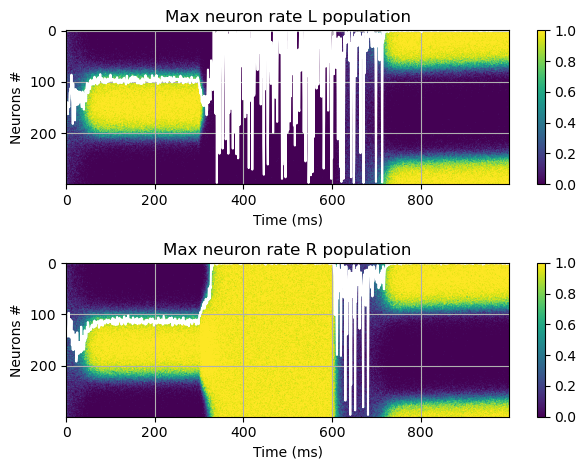

In [53]:
plt.subplot(211)
mean_rate_l = calculate_mean_rate(N, T, dt, spikes_l)
mean_over_time_l = np.mean(mean_rate_l, axis=1)
plt.imshow(mean_rate_l, aspect='auto')
plt.colorbar()
max_neuron_rate_l = []
for t in range(1, T):
    max_neuron_rate_l.append(np.argmax(mean_rate_l[:, t]))
plt.plot(max_neuron_rate_l, color='white')
plt.title('Max neuron rate L population')
plt.ylabel('Neurons #')
plt.xlabel('Time (ms)')
plt.grid()
plt.subplot(212)
mean_rate_r = calculate_mean_rate(N, T, dt, spikes_r)
mean_over_time_r = np.mean(mean_rate_r, axis=1)
plt.imshow(mean_rate_r, aspect='auto')
plt.colorbar()
max_neuron_rate_r = []
for t in range(1, T):
    max_neuron_rate_r.append(np.argmax(mean_rate_r[:, t]))
plt.plot(max_neuron_rate_r, color='white')
plt.title('Max neuron rate R population')
plt.ylabel('Neurons #')
plt.xlabel('Time (ms)')
plt.grid()
plt.tight_layout()